<a href="https://colab.research.google.com/github/MathewLipman/Work-Samples/blob/main/SQL_CIA_FACTBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anaconda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import sqlite3



In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/Dataset/factbook.db')


In [ ]:
q1 = "SELECT * FROM sqlite_master WHERE type='table';" 
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [ ]:
q2 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [ ]:
q3 = '''
SELECT MIN(Population) min_population, MAX(Population) max_population,
MIN(population_growth) min_pop_growth, MAX(population_growth) max_pop_growth
FROM facts
'''
pd.read_sql_query(q3, conn)

,min_population,max_population,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


In [ ]:
q4 = '''
SELECT MIN(birth_rate) min_birth_rate, MAX(birth_rate) max_birth_rate,
MIN(death_rate) min_death_rate, MAX(death_rate) max_death_rate
FROM facts
'''
pd.read_sql_query(q4, conn)

,min_birth_rate,max_birth_rate,min_death_rate,max_death_rate
0,6.65,45.45,1.53,14.89


Output here has a single country value thats because where or having functionality was not used so it selected the first country matching a criteria and used it for all the name values.

In [ ]:
q5 = '''
SELECT name, MIN(birth_rate) min_birth_rate, name, MAX(birth_rate) max_birth_rate,
name, MIN(death_rate) min_death_rate, name, MAX(death_rate) max_death_rate
FROM facts

'''
pd.read_sql_query(q5, conn)

,name,min_birth_rate,name,max_birth_rate,name,min_death_rate,name,max_death_rate
0,Lesotho,6.65,Lesotho,45.45,Lesotho,1.53,Lesotho,14.89


This fixed our issue - this output would work well for a ticker that runs across a screen horizontally but is not the best way to to view this data.

In [ ]:
q5 = '''
SELECT 
  (SELECT name FROM facts WHERE birth_rate = (SELECT MIN(birth_rate) FROM facts)) AS min_birth_rate_country,
  (SELECT MIN(birth_rate) FROM facts) AS min_birth_rate,
  (SELECT name FROM facts WHERE birth_rate = (SELECT MAX(birth_rate) FROM facts)) AS max_birth_rate_country,
  (SELECT MAX(birth_rate) FROM facts) AS max_birth_rate,
  (SELECT name FROM facts WHERE death_rate = (SELECT MIN(death_rate) FROM facts)) AS min_death_rate_country,
  (SELECT MIN(death_rate) FROM facts) AS min_death_rate,
  (SELECT name FROM facts WHERE death_rate = (SELECT MAX(death_rate) FROM facts)) AS max_death_rate_country,
  (SELECT MAX(death_rate) FROM facts) AS max_death_rate
'''

df = pd.read_sql_query(q5, conn)
df

,min_birth_rate_country,min_birth_rate,max_birth_rate_country,max_birth_rate,min_death_rate_country,min_death_rate,max_death_rate_country,max_death_rate
0,Monaco,6.65,Niger,45.45,Qatar,1.53,Lesotho,14.89


Using a zip loop seems like overkill but if we were working with a much larger dataset...

In [ ]:
q_min_birth_rate = '''SELECT name, birth_rate FROM facts WHERE birth_rate = (SELECT MIN(birth_rate) FROM facts)'''
q_max_birth_rate = '''SELECT name, birth_rate FROM facts WHERE birth_rate = (SELECT MAX(birth_rate) FROM facts)'''
q_min_death_rate = '''SELECT name, death_rate FROM facts WHERE death_rate = (SELECT MIN(death_rate) FROM facts)'''
q_max_death_rate = '''SELECT name, death_rate FROM facts WHERE death_rate = (SELECT MAX(death_rate) FROM facts)'''

min_birth_rate_df = pd.read_sql_query(q_min_birth_rate, conn)
max_birth_rate_df = pd.read_sql_query(q_max_birth_rate, conn)
min_death_rate_df = pd.read_sql_query(q_min_death_rate, conn)
max_death_rate_df = pd.read_sql_query(q_max_death_rate, conn)

df_list = [min_birth_rate_df, max_birth_rate_df, min_death_rate_df, max_death_rate_df]
index_list = ['Min Birth Rate', 'Max Birth Rate', 'Min Death Rate', 'Max Death Rate']

result_df = pd.DataFrame()

for df, idx in zip(df_list, index_list):
    df.columns = ['Country', 'Rate']
    df['Statistic'] = idx
    result_df = pd.concat([result_df, df])

result_df = result_df[['Statistic', 'Country', 'Rate']]
result_df


,Statistic,Country,Rate
0,Min Birth Rate,Monaco,6.65
0,Max Birth Rate,Niger,45.45
0,Min Death Rate,Qatar,1.53
0,Max Death Rate,Lesotho,14.89


Here is out to get our output in SQL

In [ ]:
q5 = '''
SELECT 'Min Birth Rate' AS Statistic, name AS Country, birth_rate AS Rate FROM facts WHERE birth_rate = (SELECT MIN(birth_rate) FROM facts)
UNION
SELECT 'Max Birth Rate' AS Statistic, name AS Country, birth_rate AS Rate FROM facts WHERE birth_rate = (SELECT MAX(birth_rate) FROM facts)
UNION
SELECT 'Min Death Rate' AS Statistic, name AS Country, death_rate AS Rate FROM facts WHERE death_rate = (SELECT MIN(death_rate) FROM facts)
UNION
SELECT 'Max Death Rate' AS Statistic, name AS Country, death_rate AS Rate FROM facts WHERE death_rate = (SELECT MAX(death_rate) FROM facts)
'''

df = pd.read_sql_query(q5, conn)
df


,Statistic,Country,Rate
0,Max Birth Rate,Niger,45.45
1,Max Death Rate,Lesotho,14.89
2,Min Birth Rate,Monaco,6.65
3,Min Death Rate,Qatar,1.53


In [ ]:
q6 = '''
SELECT name, population FROM facts
WHERE population = 0 OR population > 7000000000
'''
pd.read_sql_query(q6, conn)

,name,population
0,Antarctica,0
1,World,7256490011


<ipython-input-35-dd47117e3c13>:13: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df1.hist(ax=ax1);


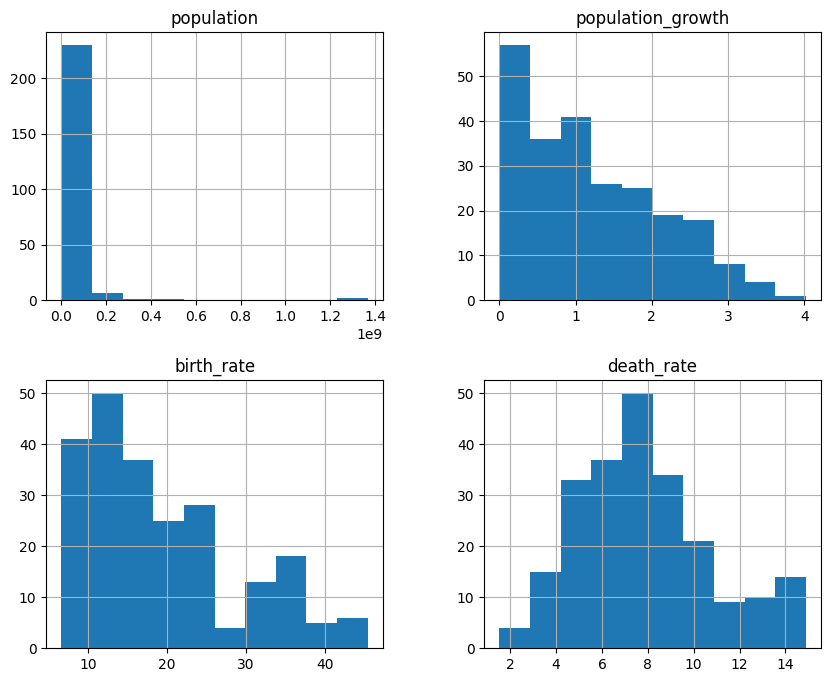

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


q7 = '''
SELECT population, population_growth, birth_rate, death_rate FROM facts
WHERE population < (SELECT MAX(Population) FROM facts) AND population > 0;
'''
df1 = pd.read_sql_query(q7, conn)

fig = plt.figure(figsize=(10,8));
ax1 = fig.add_subplot(1,1,1);
df1.hist(ax=ax1);


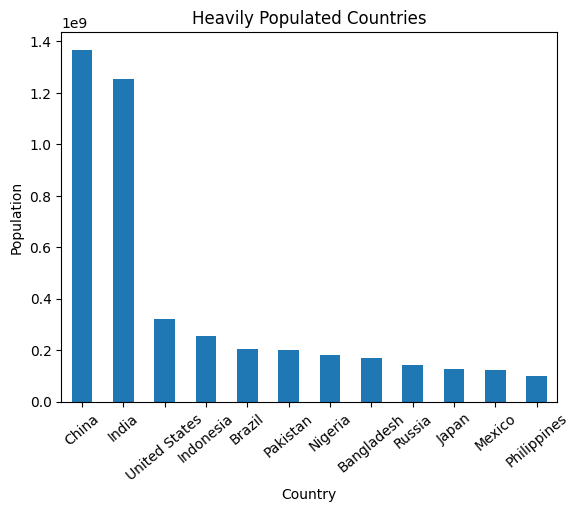

In [ ]:
q8 = '''
SELECT name heavily_populated, population FROM facts
WHERE population > 100000000 AND name != (SELECT name FROM facts WHERE name IN ('European Union'))
ORDER BY population DESC
LIMIT 15;
'''

heavily_populated = pd.read_sql_query(q8, conn)
heavily_populated = heavily_populated[heavily_populated['heavily_populated']!='World']

ax = heavily_populated.plot(x='heavily_populated', y='population', kind='bar', rot=40, legend=False)
ax.set_title('Heavily Populated Countries')
ax.set_xlabel("Country")
ax.set_ylabel("Population")
ax.grid(False);

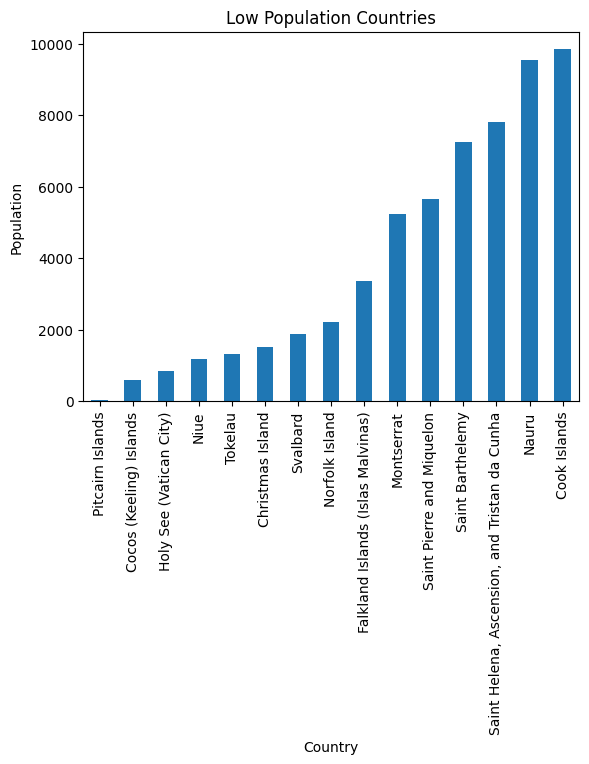

In [ ]:
q9 = '''
SELECT name AS s_populated, population FROM facts
WHERE population < 10000000 AND population > 0
ORDER BY population ASC
LIMIT 15;
'''

s_populated = pd.read_sql_query(q9, conn)

ax = s_populated.plot(x='s_populated', y='population', kind='bar', rot=90, legend=False)
ax.set_title('Low Population Countries')
ax.set_xlabel("Country")
ax.set_ylabel("Population")
ax.grid(False);


62,094,928

In [ ]:
q10 = '''
SELECT AVG(population)
FROM facts;
'''
avg_population = pd.read_sql_query(q10, conn)
avg_population

,AVG(population)
0,6.209493e+07


In [ ]:
import matplotlib.style as style
plt.style.use('dark_background')

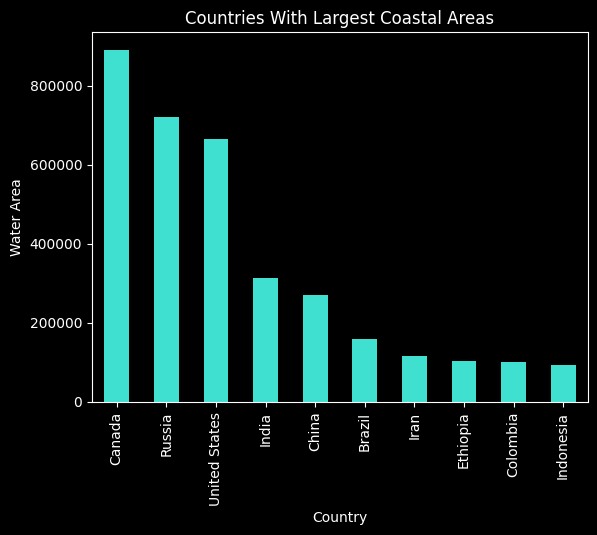

In [ ]:
q11 = '''
SELECT Name as country, area_water
FROM facts
ORDER BY area_water DESC
Limit 10;
'''
max_area_water = pd.read_sql_query(q11, conn)
max_area_water


ax = max_area_water.plot(x='country', y='area_water', kind='bar', rot=90, legend=False, 
                         color='turquoise')
ax.set_title('Countries With Largest Coastal Areas')
ax.set_xlabel("Country")
ax.set_ylabel("Water Area")
ax.grid(False);


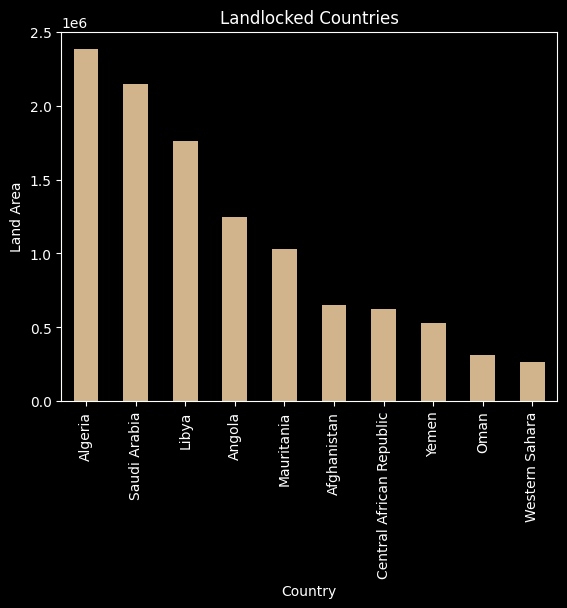

In [ ]:
q12 = '''
SELECT Name as country, area_land
FROM facts
WHERE area_water = 0
ORDER BY area_land DESC
Limit 10;
'''
max_area_land = pd.read_sql_query(q12, conn)



ax = max_area_land.plot(x='country', y='area_land', kind='bar', rot=90, legend=False, color='tan')
ax.set_title('Landlocked Countries')
ax.set_xlabel("Country")
ax.set_ylabel("Land Area")
ax.grid(False);


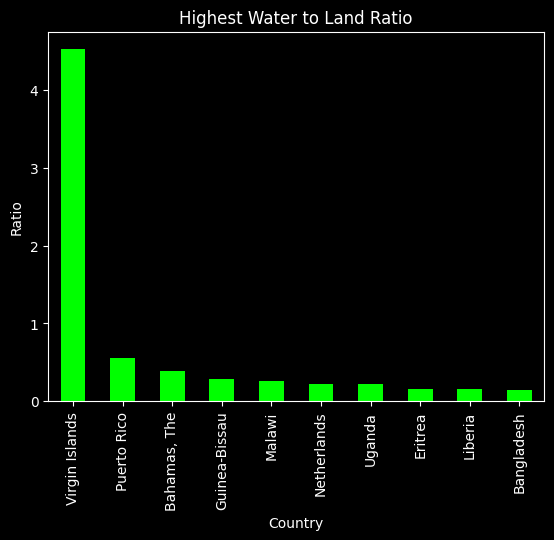

In [ ]:
q13 = '''
SELECT Name as country, (CAST(area_water AS FLOAT) / CAST(area_land AS FLOAT)) AS water_ratio
FROM facts
WHERE area_land > 100
ORDER BY water_ratio DESC
LIMIT 10;
'''

island_nations = pd.read_sql_query(q13, conn)

ax = island_nations.plot(x='country', y='water_ratio', kind='bar', rot=90, legend=False, color='lime')
ax.set_title('Highest Water to Land Ratio')
ax.set_xlabel("Country")
ax.set_ylabel("Ratio")
ax.grid(False);


In [ ]:
q14 = '''
SELECT 'Min Migration Rate' AS Statistic, name AS Country, migration_rate FROM facts WHERE migration_rate = (SELECT MIN(migration_rate) FROM facts WHERE migration_rate > 0)
UNION
SELECT 'Max Migration Rate' AS Statistic, name AS Country, migration_rate FROM facts WHERE migration_rate = (SELECT MAX(migration_rate) FROM facts)
LIMIT 2
'''


df = pd.read_sql_query(q14, conn)
df


,Statistic,Country,migration_rate
0,Max Migration Rate,Qatar,22.39
1,Min Migration Rate,India,0.04


In [ ]:
q15 = '''
SELECT name AS Country, migration_rate FROM facts 
ORDER BY migration_rate DESC
Limit 10
'''


df = pd.read_sql_query(q15, conn)
df


,Country,migration_rate
0,Qatar,22.39
1,American Samoa,21.13
2,"Micronesia, Federated States of",20.93
3,Syria,19.79
4,Tonga,17.84
5,British Virgin Islands,17.28
6,Luxembourg,17.16
7,Cayman Islands,14.40
8,Singapore,14.05
9,Nauru,13.63


In [ ]:
q16 = '''
SELECT name AS Country, migration_rate, population_growth FROM facts
ORDER BY migration_rate DESC, population_growth
Limit 10
'''


df = pd.read_sql_query(q16, conn)
df


,Country,migration_rate,population_growth
0,Qatar,22.39,3.07
1,American Samoa,21.13,0.30
2,"Micronesia, Federated States of",20.93,0.46
3,Syria,19.79,0.16
4,Tonga,17.84,0.03
5,British Virgin Islands,17.28,2.32
6,Luxembourg,17.16,2.13
7,Cayman Islands,14.40,2.10
8,Singapore,14.05,1.89
9,Nauru,13.63,0.55


In [ ]:
q17 = '''
SELECT name AS Country, migration_rate, population_growth FROM facts
ORDER BY population_growth DESC
Limit 10
'''


df = pd.read_sql_query(q17, conn)
df

,Country,migration_rate,population_growth
0,South Sudan,11.47,4.02
1,Malawi,0.00,3.32
2,Burundi,0.00,3.28
3,Niger,0.56,3.25
4,Uganda,0.74,3.24
5,Qatar,22.39,3.07
6,Burkina Faso,0.00,3.03
7,Mali,2.26,2.98
8,Cook Islands,NaN,2.95
9,Iraq,1.62,2.93


In [ ]:
df = pd.read_sql_query(q2, conn)
df

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [ ]:
q18 = """
SELECT name AS Country, 
       area, 
       population,
       CAST (population as FLOAT) / area AS Pop_density
FROM facts
WHERE population > 0 AND area > 1000
AND population IS NOT NULL AND area IS NOT NULL
ORDER BY Pop_density ASC

LIMIT 10;
"""

df = pd.read_sql_query(q18, conn)
df

,Country,area,population,Pop_density
0,Greenland,2166086,57733,0.026653
1,Svalbard,62045,1872,0.030172
2,Falkland Islands (Islas Malvinas),12173,3361,0.276103
3,Mongolia,1564116,2992908,1.913482
4,Western Sahara,266000,570866,2.146113
5,Namibia,824292,2212307,2.683888
6,Australia,7741220,22751014,2.938944
7,Iceland,103000,331918,3.222505
8,Guyana,214969,735222,3.420130
9,Mauritania,1030700,3596702,3.489572


In [ ]:
q19 = """
SELECT name AS Country, 
       area, 
       population,
       CAST (population as FLOAT) / area AS Pop_density
FROM facts
WHERE population > 0 AND area > 1000
AND population IS NOT NULL AND area IS NOT NULL
ORDER BY Pop_density DESC

LIMIT 10;
"""

df = pd.read_sql_query(q19, conn)
df

,Country,area,population,Pop_density
0,Hong Kong,1108,7141106,6445.041516
1,Bangladesh,148460,168957745,1138.069143
2,Mauritius,2040,1339827,656.777941
3,Taiwan,35980,23415126,650.781712
4,Lebanon,10400,6184701,594.682788
5,"Korea, South",99720,49115196,492.531047
6,Rwanda,26338,12661733,480.740109
7,West Bank,5860,2785366,475.318430
8,Netherlands,41543,16947904,407.960523
9,Israel,20770,8049314,387.545209


In [ ]:
q20 = '''
SELECT AVG(area)
FROM facts;
'''
avg_population = pd.read_sql_query(q20, conn)
avg_population

,AVG(area)
0,555093.546185


In [ ]:
q21 = """
SELECT name AS Country, 
       area, 
       population,
       CAST (population as FLOAT) / area AS Pop_density
FROM facts
WHERE population > 0 AND area > 555093
AND population IS NOT NULL AND area IS NOT NULL
ORDER BY Pop_density DESC

LIMIT 10;
"""

df = pd.read_sql_query(q21, conn)
df

,Country,area,population,Pop_density
0,India,3287263,1251695584,380.771354
1,Pakistan,796095,199085847,250.078002
2,Nigeria,923768,181562056,196.545081
3,China,9596960,1367485388,142.491517
4,Indonesia,1904569,255993674,134.410291
5,European Union,4324782,513949445,118.838232
6,France,643801,66553766,103.376301
7,Turkey,783562,79414269,101.350332
8,Ethiopia,1104300,99465819,90.071375
9,Egypt,1001450,88487396,88.359275


In [ ]:
q22 = """
SELECT name AS Country, 
       area, 
       population,
       CAST (population as FLOAT) / area AS Pop_density
FROM facts
WHERE population > 0 AND area > 555093
AND population IS NOT NULL AND area IS NOT NULL
ORDER BY Pop_density ASC

LIMIT 10;
"""

df = pd.read_sql_query(q22, conn)
df

,Country,area,population,Pop_density
0,Greenland,2166086,57733,0.026653
1,Mongolia,1564116,2992908,1.913482
2,Namibia,824292,2212307,2.683888
3,Australia,7741220,22751014,2.938944
4,Mauritania,1030700,3596702,3.489572
5,Canada,9984670,35099836,3.515373
6,Libya,1759540,6411776,3.644007
7,Botswana,581730,2182719,3.752117
8,Kazakhstan,2724900,18157122,6.663409
9,Russia,17098242,142423773,8.329732


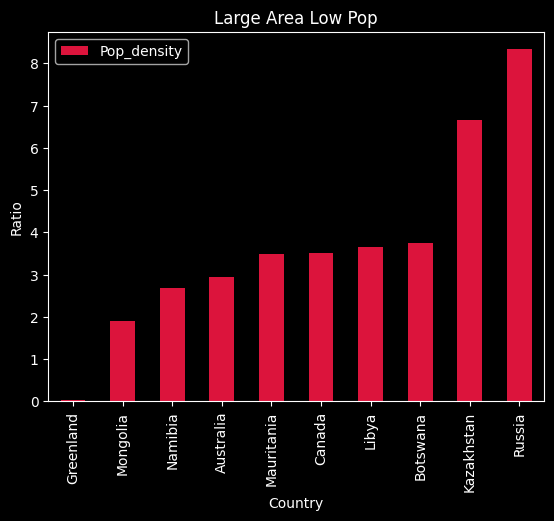

In [ ]:
q22c = """
SELECT name AS Country, 
       area, 
       population,
       CAST (population as FLOAT) / area AS Pop_density
FROM facts
WHERE population > 0 AND area > 555093
AND population IS NOT NULL AND area IS NOT NULL
ORDER BY Pop_density ASC

LIMIT 10;
"""
low_pop_d = pd.read_sql_query(q22c, conn)

ax = low_pop_d.plot(x='Country', y='Pop_density', kind='bar', rot=90, legend=True, color='crimson')
ax.set_title('Large Area Low Pop')
ax.set_xlabel("Country")
ax.set_ylabel("Ratio")
ax.grid(False);

In [ ]:
q23 = """
SELECT name AS Country, 
       area, 
       population,
       CAST (population as FLOAT) / area AS Pop_density
FROM facts
WHERE population > 0 AND area < 555093
AND population IS NOT NULL AND area IS NOT NULL
ORDER BY Pop_density DESC

LIMIT 10;
"""

df = pd.read_sql_query(q23, conn)
df

,Country,area,population,Pop_density
0,Macau,28,592731,21168.964286
1,Monaco,2,30535,15267.500000
2,Singapore,697,5674472,8141.279770
3,Hong Kong,1108,7141106,6445.041516
4,Gaza Strip,360,1869055,5191.819444
5,Gibraltar,6,29258,4876.333333
6,Bahrain,760,1346613,1771.859211
7,Maldives,298,393253,1319.640940
8,Malta,316,413965,1310.015823
9,Bermuda,54,70196,1299.925926
